# <center> Econometria Financiera <center>
    
    

<center> Aura Gonzalez 1106920<center>

    

#### Import and Data Loading

In [34]:
import numpy as np
import pandas as pd
import scipy
from scipy.stats import skew
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import pingouin as pg
from scipy.stats.stats import pearsonr
from scipy import stats

pd.options.display.float_format = "{:,.4f}".format

sns.set_style("whitegrid")
sns.set()

!pip install PrettyTable 

In [3]:
path = "/Users/Aura/Desktop/momentum_data.xlsx"

#cargando Factores Fama French
FF_factors = pd.read_excel(path,sheet_name=1)
FF_factors.set_index('Date',inplace=True)
FF_factors.tail(5)




,MKT,SMB,HML
Date,,,
2021-05-31,0.0029,-0.0028,0.0704
2021-06-30,0.0275,0.0180,-0.0776
2021-07-31,0.0127,-0.0396,-0.0175
2021-08-31,0.0290,-0.0048,-0.0013
2021-09-30,-0.0437,0.0080,0.0509


In [4]:
#cargando Factor Fama French de Momentum
FF_mom = pd.read_excel(path,sheet_name=2)
FF_mom.set_index('Date',inplace=True)
FF_mom.tail(5)



,UMD
Date,
2021-05-31,0.0088
2021-06-30,0.0224
2021-07-31,-0.0229
2021-08-31,0.0252
2021-09-30,0.0157


In [5]:
#cargando retorno de deciles de momentum
dec_mom = pd.read_excel(path,sheet_name=3)
dec_mom.set_index('Date',inplace=True)
dec_mom.tail(5)


,Lo PRIOR,PRIOR 2,PRIOR 3,PRIOR 4,PRIOR 5,PRIOR 6,PRIOR 7,PRIOR 8,PRIOR 9,Hi PRIOR
Date,,,,,,,,,,
2021-05-31,-0.0004,0.0149,-0.0132,0.0141,0.0181,-0.0033,0.0203,0.0217,0.0190,-0.0478
2021-06-30,0.0231,0.0050,0.0168,0.0498,-0.0052,0.0434,0.0153,-0.0082,0.0218,0.0894
2021-07-31,-0.0031,0.0171,0.0341,0.0327,0.0155,0.0217,-0.0124,-0.0094,-0.0205,-0.0047
2021-08-31,-0.0027,0.0204,0.0257,0.0409,0.0250,0.0152,0.0436,0.0599,0.0366,0.0295
2021-09-30,-0.0350,-0.0531,-0.0597,-0.0462,-0.0359,-0.0450,-0.0419,-0.0330,-0.0256,-0.0322


In [6]:
#cargando retorno de deciles de momentum por size
dec_mom_size = pd.read_excel(path,sheet_name=4)
dec_mom_size.set_index('Date',inplace=True)
dec_mom_size.tail(5)


,SMALL LoPRIOR,ME1 PRIOR2,SMALL HiPRIOR,BIG LoPRIOR,ME2 PRIOR2,BIG HiPRIOR
Date,,,,,,
2021-05-31,-0.0020,0.0171,0.0236,-0.0021,0.0103,-0.0101
2021-06-30,0.0195,-0.0007,0.0444,0.0131,0.0346,0.0330
2021-07-31,-0.0342,-0.0232,-0.0529,0.0226,0.0214,-0.0045
2021-08-31,0.0073,0.0242,0.0274,0.0186,0.0329,0.0489
2021-09-30,-0.0302,-0.0271,-0.0173,-0.0509,-0.0431,-0.0325


In [7]:
#cargando tasa libre de riesgo
rf = pd.read_excel(path,sheet_name=5)
rf.set_index('Date',inplace=True)
rf.tail(5)

,RF
Date,
2021-05-31,0.0000
2021-06-30,0.0000
2021-07-31,0.0000
2021-08-31,0.0000
2021-09-30,0.0000


### AQR’s Fondos de Impulso (Momentum).

#### 1. El Producto del Momentum

1. ¿Cuál es la novedad sobre el producto nuevo de Momentum (Impulso) comparado con otros productos de momentum ya ofrecidos en el mercado? 

La novedad del nuevo producto de momentum es la rentabilidad relativa como componente clave, donde AQR definía el impulso de las acciones de capital como ‘el fenómeno por el cual las acciones que han rendido bien en el pasado (ganadoras), en comparación con otras acciones, seguían rindiendo bien en el futuro y las acciones que se comportaron relativamente mal (perdedoras) seguían comportándose mal’, ya que implicaba la existencia de la estrategia y la capacidad de implementarla, independientemente de los mercados alcistas o bajistas.



2. Nombre dos razones por el cual un producto de inversión de Momentum no replicará exactamente un índice de momentum, (es decir, porque existirá tracking error o error de seguimiento).

Aunque el UMD era transparente y muy aceptado en la academia, no era un índice adecuado para los productos de impulso que AQR tenía el propósito de lanzar. Primero, el UMD tomaba posiciones largas-cortas, mientras que el fondo de AQR sería únicamente con posiciones largas. Segundo, el UMD se rebalanceaba mensualmente, lo que exigiría replicar una enorme cantidad de operaciones. Tercero, el UMD utilizaba todas las acciones cotizadas, mientras que AQR quería utilizar únicamente las acciones que tuvieran una capitalización de mercado y una liquidez razonables, ya que la característica “abierta” de los fondos mutualistas necesitaba una cierta cantidad de liquidez diaria en el producto.




#### 2. Invirtiendo en Momentum.

En esta sección, investigaremos empíricamente algunas de las preocupaciones relacionadas con el nuevo producto de momentum de AQR. Para esto utilizaremos el data file “momentum_data.xlsx”.

• La primera hoja contiene los factores de impulso o momentum en exceso de retorno: 𝑟𝑟̃𝑚𝑚𝑚𝑚𝑚𝑚.

• La segunda hoja contiene los retornos sobre portafolios correspondientes a los deciles ranqueados de por momentum.

o 𝑟𝑟̃ 𝑚o𝑚(1) denota el portafolio de acciones en el decil más bajo por momentum, los “perdedores” con los retornos más bajos en el pasado.

o 𝑟𝑟̃ 𝑚o𝑚(10) denota el portafolio de acciones con el decil mas alto del momento, los ganadores con los retornos mas altos en el pasado

1. ¿Todavía genera beneficios la estrategia de Momentum?

Los excesos de retornos de estrategias de inversión lucrativas tienden a desaparecer una vez una estrategia es bien conocida. La primera investigación citada de momentum fue publicada en 1993. ¿Han cambiado los retornos de la estrategia de momentum o el riesgo desde este tiempo? El caso de estudio AQR toma lugar a final del 2008. ¿Han cambiado los retornos de momentum de 2009 a 2021?

Investigue llenando la tabla de resumen estadístico mas abajo para la muestra completa y tres submuestras.

In [8]:

# Submuestras
subsample1 = FF_factors.loc[:'9/30/2021']
subsample2 = FF_factors.loc['1/31/1927':'12/31/1993']
subsample3 = FF_factors.loc['1/31/1994': '12/31/2008']
subsample4 = FF_factors.loc['1/31/2009':]


# Submuestras para momentums
subsample11 = FF_mom.loc[:'9/30/2021']
subsample22 = FF_mom.loc['1/31/1927':'12/31/1993']
subsample33 = FF_mom.loc['1/31/1994': '12/31/2008']
subsample44 = FF_mom.loc['1/31/2009':]


table 1. Momentum performance over time

In [35]:
# Calcular las estadísticas para cada submuestra
def calcular_estadisticas(data, data2):
    media = data.mean()
    volatilidad = data.std()
    sharpe_ratio = media / volatilidad
    Skewness = skew(data, axis=0, bias=True)
    cor1 = stats.pearsonr(data['MKT'], data2['UMD'])[0]
    cor2 = stats.pearsonr(data['HML'], data2['UMD'])[0]
    return media, volatilidad, sharpe_ratio, Skewness, cor1, cor2

# Obtener las estadísticas para cada submuestra
stats_subsample1 = calcular_estadisticas(subsample1, subsample11)
stats_subsample2 = calcular_estadisticas(subsample2, subsample22)
stats_subsample3 = calcular_estadisticas(subsample3, subsample33)
stats_subsample4 = calcular_estadisticas(subsample4, subsample44)

# Crear una tabla con los estadísticos para cada submuestra

headers = ["Submuestra", "Media", "Volatilidad", "Sharpe Ratio", "Skewness", "Corr to rm", "Corr to rv"]

table = [
    ["1927 - 2021"] + list(stats_subsample1),
    ["1927 - 1993"] + list(stats_subsample2),
    ["1994 - 2008"] + list(stats_subsample3),
    ["2009 - 2021"] + list(stats_subsample4)
]

# Imprimir la tabla
from prettytable import PrettyTable as pt
tb = pt()

#Add headers
tb.field_names = headers

tb.add_row(table[0])
tb.add_row(table[1])
tb.add_row(table[2])
tb.add_row(table[3])

print(tb)

+-------------+----------------+----------------+----------------+---------------------------------------+----------------------+----------------------+
|  Submuestra |     Media      |  Volatilidad   |  Sharpe Ratio  |                Skewness               |      Corr to rm      |      Corr to rv      |
+-------------+----------------+----------------+----------------+---------------------------------------+----------------------+----------------------+
| 1927 - 2021 |  MKT   0.0068  |  MKT   0.0535  |  MKT   0.1280  |   [0.16690317 1.85476278 2.12908527]  | -0.34483551484915276 | -0.4243818131143424  |
|             |  SMB   0.0021  |  SMB   0.0318  |  SMB   0.0655  |                                       |                      |                      |
|             |  HML   0.0034  |  HML   0.0354  |  HML   0.0947  |                                       |                      |                      |
|             | dtype: float64 | dtype: float64 | dtype: float64 |                

b) Utilizando los estadísticos de las diferentes submuestras ¿Ha cambiado el momentum a través del tiempo?
c) ¿Acaso la data apoya el argumento de AQR de que el momentum es una pieza importante de un portafolio ideal? ¿El momentum seria valioso aun si los retornos promedios fueran cercanos a cero si incluyéramos los costos de transacción?


A traves del tiempo el momentum ha cambiado debido a que la volativilidad ha disminuido, la correlacion ha variado significativamente y el sharpe ratio ha mostrado cambios sinificativos, segun lo observaod se puede decir que el momentum seria valioso aun si los retornos promedios fueran cercanos a cero su incluyeramos los costos de transaccion.

2. El caso es de si solo la implementación long del momentum es valiosa. Construya su propia implementación long-only1:

a) Complete la Tabla 2 para los datos en el periodo 1994-2021.


In [36]:
dec_mom_size2 = dec_mom_size.loc['1/31/1994':'9/30/2021']
dec_mom2 = dec_mom.loc['1/31/1994':'9/30/2021']
FF_factors2 = FF_factors.loc['1/31/1994':'9/30/2021']

In [37]:
DF_Ejemplos = pd.DataFrame(index=FF_factors2.index)

DF_Ejemplos['FF_Momentum'] = 1/2*(dec_mom_size2['SMALL HiPRIOR']+dec_mom_size2['BIG HiPRIOR'])-1/2*(dec_mom_size2['SMALL LoPRIOR']+dec_mom_size2['BIG LoPRIOR'])

DF_Ejemplos.tail(5)

,FF_Momentum
Date,
2021-05-31,0.0088
2021-06-30,0.0224
2021-07-31,-0.0229
2021-08-31,0.0252
2021-09-30,0.0157


In [38]:
DF_Ejemplos['Long-Only mom'] = 1/2*(dec_mom_size2['SMALL HiPRIOR']+dec_mom_size2['BIG HiPRIOR'])-rf['RF']
DF_Ejemplos.tail(5)

,FF_Momentum,Long-Only mom
Date,,
2021-05-31,0.0088,0.0067
2021-06-30,0.0224,0.0387
2021-07-31,-0.0229,-0.0287
2021-08-31,0.0252,0.0382
2021-09-30,0.0157,-0.0249


In [39]:
#### Table 2. Long-only momentum performance

In [40]:
# Calcular las estadísticas para cada submuestra
def calcular_estadisticas(data, data2):
    media = data.mean()
    volatilidad = data.std()
    sharpe_ratio = media / volatilidad
    Skewness = skew(data, axis=0, bias=True)
    cor1 = stats.pearsonr(data, data2['MKT'])[0]
    cor2 = stats.pearsonr(data, data2['HML'])[0]
    return media, volatilidad, sharpe_ratio, Skewness, cor1, cor2

# Obtener las estadísticas para cada submuestra
stats_subsample1 = calcular_estadisticas(DF_Ejemplos['FF_Momentum'], FF_factors.loc['1/31/1994':'9/30/2021'])
stats_subsample2 = calcular_estadisticas(DF_Ejemplos['Long-Only mom'], FF_factors.loc['1/31/1994':'9/30/2021'])

# Crear una tabla con los estadísticos para cada submuestra

headers = ["Submuestra", "Media", "Volatilidad", "Sharpe Ratio", "Skewness", "Corr to rm", "Corr to rv"]

table = [
    ["Long-and-short"] + list(stats_subsample1),
    ["Long-only"] + list(stats_subsample2),
]

# Imprimir la tabla
from prettytable import PrettyTable as pt
tb = pt()

#Add headers
tb.field_names = headers

tb.add_row(table[0])
tb.add_row(table[1])


print(tb)

+----------------+-----------------------+---------------------+---------------------+---------------------+---------------------+----------------------+
|   Submuestra   |         Media         |     Volatilidad     |     Sharpe Ratio    |       Skewness      |      Corr to rm     |      Corr to rv      |
+----------------+-----------------------+---------------------+---------------------+---------------------+---------------------+----------------------+
| Long-and-short | 0.0036897897897897867 | 0.04931542563618983 | 0.07482019555118787 | -1.4043094088527555 | -0.3064793606707641 | -0.25426032402337206 |
|   Long-only    |  0.010305255255255255 | 0.05114917420641219 | 0.20147451870226601 | -0.4996056509477409 |  0.9001976700928773 | -0.1373757944252552  |
+----------------+-----------------------+---------------------+---------------------+---------------------+---------------------+----------------------+


    b) ¿Es acaso long-only momentum igual de atractivo como long-short momentum con respecto a la media, volatilidad, y Sharpe Ratio?
No, debido a que el long-short tiene mayor retorno, la volatibilidad es menor y el sharpe ratio, lo que significa que el Long-and short ha oscilado menos que el long-only como e sharpe ratio es mayor, esto nos dice que mejor ha sido la  rentabilidad del fondo en relación a la cantidad de riesgo que se ha tomado en la inversión

    c) ¿Es acaso long-only momentum tan diversificador como el long-short momentum con respecto al mercado y la prima de valor(value)?


    d) Muestre un gráfico del producto acumulativo de 1 + 𝑟mom:𝐹𝐹 y 1 + 𝑟𝑈:𝐹𝐹 de 1994-2021.

<AxesSubplot:xlabel='Date'>

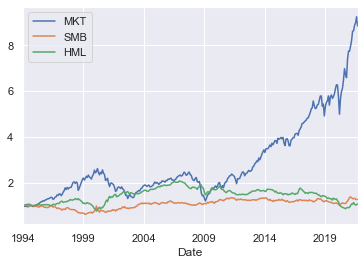

In [41]:
(1+FF_factors.loc['1/31/1994':'9/30/2021']).cumprod().plot()

#### 3. ¿Es momentum data mining, o es una estrategia robusta?

Analice que tan sensible es el rango para los “ganadores” y los “perdedores” en los resultados. Específicamente, compararemos tres construcciones:



• Long el decil top 1 con el mayor nivel de momentum y short el decil top 1 con menor nivel de momentum.


In [42]:
DF_Ejemplos['momD1'] = dec_mom2['Hi PRIOR']-dec_mom2['Lo PRIOR']
DF_Ejemplos.tail(5)

,FF_Momentum,Long-Only mom,momD1
Date,,,
2021-05-31,0.0088,0.0067,-0.0474
2021-06-30,0.0224,0.0387,0.0663
2021-07-31,-0.0229,-0.0287,-0.0016
2021-08-31,0.0252,0.0382,0.0322
2021-09-30,0.0157,-0.0249,0.0028



• Long los deciles top 3 con el mayor nivel de momentum y short los deciles top 3 con el menor nivel de momentum.


In [43]:
DF_Ejemplos['momD3'] = 1/3*(dec_mom2['PRIOR 8']+dec_mom2['PRIOR 9']+dec_mom2['Hi PRIOR'])-1/3*(dec_mom2['Lo PRIOR']+dec_mom2['PRIOR 2']+dec_mom2['PRIOR 3'])
DF_Ejemplos.tail(5)

,FF_Momentum,Long-Only mom,momD1,momD3
Date,,,,
2021-05-31,0.0088,0.0067,-0.0474,-0.0028
2021-06-30,0.0224,0.0387,0.0663,0.0194
2021-07-31,-0.0229,-0.0287,-0.0016,-0.0276
2021-08-31,0.0252,0.0382,0.0322,0.0275
2021-09-30,0.0157,-0.0249,0.0028,0.0190



• Long los deciles top 5 con el mayor nivel de momentum y short los deciles top 5 con el menor nivel de momentum.


In [44]:
DF_Ejemplos['momD5'] = 1/5*(dec_mom2['PRIOR 6']+dec_mom2['PRIOR 7']+dec_mom2['PRIOR 8']+dec_mom2['PRIOR 9']+dec_mom2['Hi PRIOR'])-1/5*(dec_mom2['Lo PRIOR']+dec_mom2['PRIOR 2']+dec_mom2['PRIOR 3']+dec_mom2['PRIOR 4']+dec_mom2['PRIOR 5'])
DF_Ejemplos.tail(5)

,FF_Momentum,Long-Only mom,momD1,momD3,momD5
Date,,,,,
2021-05-31,0.0088,0.0067,-0.0474,-0.0028,-0.0047
2021-06-30,0.0224,0.0387,0.0663,0.0194,0.0144
2021-07-31,-0.0229,-0.0287,-0.0016,-0.0276,-0.0243
2021-08-31,0.0252,0.0382,0.0322,0.0275,0.0151
2021-09-30,0.0157,-0.0249,0.0028,0.0190,0.0104


a) Compare las tres construcciones, (utilizando toda la muestra), completando los estadísticos en la tabla mas abajo para el periodo 1994-2021.


#### Tabla 3. Robustness of momentum construction

In [45]:
# Calcular las estadísticas para cada submuestra
def calcular_estadisticas(data, data2):
    media = data.mean()
    volatilidad = data.std()
    sharpe_ratio = media / volatilidad
    Skewness = skew(data, axis=0, bias=True)
    cor1 = stats.pearsonr(data, data2['MKT'])[0]
    cor2 = stats.pearsonr(data, data2['HML'])[0]
    return media, volatilidad, sharpe_ratio, Skewness, cor1, cor2

# Obtener las estadísticas para cada submuestra
stats_subsample1 = calcular_estadisticas(DF_Ejemplos['momD1'], FF_factors.loc['1/31/1994':'9/30/2021'])
stats_subsample2 = calcular_estadisticas(DF_Ejemplos['momD3'], FF_factors.loc['1/31/1994':'9/30/2021'])
stats_subsample3 = calcular_estadisticas(DF_Ejemplos['momD5'], FF_factors.loc['1/31/1994':'9/30/2021'])

# Crear una tabla con los estadísticos para cada submuestra

headers = ["Submuestra", "Media", "Volatilidad", "Sharpe Ratio", "Skewness", "Corr to rm", "Corr to rv"]

table = [
    ["momD1"] + list(stats_subsample1),
    ["momD3"] + list(stats_subsample2),
    ["momD5"] + list(stats_subsample2)
]

# Imprimir la tabla
from prettytable import PrettyTable as pt
tb = pt()

#Add headers
tb.field_names = headers

tb.add_row(table[0])
tb.add_row(table[1])
tb.add_row(table[2])


print(tb)

+------------+----------------------+---------------------+---------------------+--------------------+----------------------+---------------------+
| Submuestra |        Media         |     Volatilidad     |     Sharpe Ratio    |      Skewness      |      Corr to rm      |      Corr to rv     |
+------------+----------------------+---------------------+---------------------+--------------------+----------------------+---------------------+
|   momD1    | 0.006095195195195201 | 0.08713295463871998 | 0.06995281200399726 | -1.295439439327096 | -0.33371033343282963 | -0.2586566242628672 |
|   momD3    | 0.002644844844844847 | 0.05619125393713029 |  0.0470686211737513 | -1.336981147261928 | -0.36540591478876294 | -0.2370382379235681 |
|   momD5    | 0.002644844844844847 | 0.05619125393713029 |  0.0470686211737513 | -1.336981147261928 | -0.36540591478876294 | -0.2370382379235681 |
+------------+----------------------+---------------------+---------------------+--------------------+----------

    b) ¿Acaso el intercambio de retornos (máximos “perdedores” vs máximos “ganadores”) entre las construcciones decil-1, decil-3, decil-5 se alinean con los intercambios de retornos teóricos que se comentan en la ppt de momentum vista en clase?
Si, se puede decir que se alian un poco segun lo visto en clase.



    c) ¿Acaso el producto de AQR considera una construcción de momentum decil-1 o decil-5?
Si, considera una construccion de momemtum decil-1.

    d) ¿Acaso 𝑟𝑟̃𝑚on3 tiene estadísticos similares la construcción Fama-French mas arriba. Recuerde que la construcción es también decil-3, long-short, pero que esta segmentada por acciones “large” y “small” en términos de capitalización. Compare la fila del medio de la tabla 3 con la parte superior de la Tabla 2.
Tienen diferencias significativas, que muestran que hay diferencias entre ellas.




#### 4. ¿Acaso implementar una estrategia de momentum requiere invertir en un gran número de acciones “small”, por ende, causando costos de transacción más altos?



Por razones regulatorias y de liquidez, AQR esta particularmente interesada en usar acciones categorizadas como “large” para su canaste de acciones momentum. (Aunque ellos van a lanzar un producto que se enfoca en acciones de tamaño “médium”).

Use los datos provistos sobre los “ganadores” de las acciones small, 𝒓𝒓mo𝒎, y los “perdedores”, 𝒓𝒓𝒎o𝒎, para construir un portafolio small de momentum,
 Similarmente, use la data provista para construir un portafolio large de momentum.


a) Completa la Tabla 4 usando la muestra de 1994-2021.

In [46]:
DF_Ejemplos['moms'] = dec_mom_size2['BIG HiPRIOR']-dec_mom_size['BIG LoPRIOR']
DF_Ejemplos.tail(5)

,FF_Momentum,Long-Only mom,momD1,momD3,momD5,moms
Date,,,,,,
2021-05-31,0.0088,0.0067,-0.0474,-0.0028,-0.0047,-0.0080
2021-06-30,0.0224,0.0387,0.0663,0.0194,0.0144,0.0199
2021-07-31,-0.0229,-0.0287,-0.0016,-0.0276,-0.0243,-0.0271
2021-08-31,0.0252,0.0382,0.0322,0.0275,0.0151,0.0303
2021-09-30,0.0157,-0.0249,0.0028,0.0190,0.0104,0.0184


In [47]:
DF_Ejemplos['momb']= dec_mom_size2['SMALL HiPRIOR'] - dec_mom_size2['SMALL LoPRIOR']
DF_Ejemplos.tail(5)

,FF_Momentum,Long-Only mom,momD1,momD3,momD5,moms,momb
Date,,,,,,,
2021-05-31,0.0088,0.0067,-0.0474,-0.0028,-0.0047,-0.0080,0.0256
2021-06-30,0.0224,0.0387,0.0663,0.0194,0.0144,0.0199,0.0249
2021-07-31,-0.0229,-0.0287,-0.0016,-0.0276,-0.0243,-0.0271,-0.0187
2021-08-31,0.0252,0.0382,0.0322,0.0275,0.0151,0.0303,0.0201
2021-09-30,0.0157,-0.0249,0.0028,0.0190,0.0104,0.0184,0.0129


In [48]:
# Obtener las estadísticas para cada submuestra
stats_subsample1 = calcular_estadisticas(DF_Ejemplos['FF_Momentum'], FF_factors.loc['1/31/1994':'9/30/2021'])
stats_subsample2 = calcular_estadisticas(DF_Ejemplos['moms'], FF_factors.loc['1/31/1994':'9/30/2021'])
stats_subsample3 = calcular_estadisticas(DF_Ejemplos['momb'], FF_factors.loc['1/31/1994':'9/30/2021'])

# Crear una tabla con los estadísticos para cada submuestra

headers = ["Submuestra", "Media", "Volatilidad", "Sharpe Ratio", "Skewness", "Corr to rm", "Corr to rv"]

table = [
    ["All stocks"] + list(stats_subsample1),
    ["Small stocks"] + list(stats_subsample2),
    ["Large stocks"] + list(stats_subsample2)
]

# Imprimir la tabla
from prettytable import PrettyTable as pt
tb = pt()

#Add headers
tb.field_names = headers

tb.add_row(table[0])
tb.add_row(table[1])
tb.add_row(table[2])


print(tb)

+--------------+-----------------------+---------------------+---------------------+---------------------+---------------------+----------------------+
|  Submuestra  |         Media         |     Volatilidad     |     Sharpe Ratio    |       Skewness      |      Corr to rm     |      Corr to rv      |
+--------------+-----------------------+---------------------+---------------------+---------------------+---------------------+----------------------+
|  All stocks  | 0.0036897897897897867 | 0.04931542563618983 | 0.07482019555118787 | -1.4043094088527555 | -0.3064793606707641 | -0.25426032402337206 |
| Small stocks | 0.0025699699699699673 |  0.0530206807713455 | 0.04847108585898961 | -0.8436296222552364 | -0.2774035748411821 | -0.29078598869628874 |
| Large stocks | 0.0025699699699699673 |  0.0530206807713455 | 0.04847108585898961 | -0.8436296222552364 | -0.2774035748411821 | -0.29078598869628874 |
+--------------+-----------------------+---------------------+---------------------+----

b) ¿El atractivo de la estrategia de momentum está impulsada por las acciones “small”? Es decir, ¿Acaso la estrategia de momentum todavía genera exceso de retorno a riesgo comparable?

No, debido a que tanto las short como las large stocks tienen los mismos estadisticos, por lo que la estraegia de momentum es variable.

#### 5. En conclusión, ¿Cuál es su evaluación del producto AQR? ¿Está capturando características de la construcción Fama-French de momentum? ¿Propondría usted alguna modificación?



Para evaluar el desempeño del producto AQR, agregando a los 3 factores del modelo de Fama-French (MKT, SMB, HML) un nuevo factor; WML. Este último imita el momentum del retorno de un portafolio para un año y testea el desempeño del modelo en conjunto con el modelo CAPM y 3-Factores de Fama y French, mediante deciles de portafolios formados cada año a partir de los retornos del año calendario anterior.